# Extract Data


In [1]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import requests


In [2]:
# create dataframe
beer_df = pd.read_csv('https://query.data.world/s/nuub3qupegsd33g3nimifjpajqeq2o')

# drop all rows with any NaN values
beer_df.dropna(inplace=True)

# remove duplicate rows in place
beer_df.drop_duplicates(inplace=True)
beer_df


,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586609,14359,The Defiant Brewing Company,1162684892,5.0,4.0,3.5,maddogruss,Pumpkin Ale,4.0,4.0,The Horseman's Ale,5.2,33061
1586610,14359,The Defiant Brewing Company,1161048566,4.0,5.0,2.5,yelterdow,Pumpkin Ale,2.0,4.0,The Horseman's Ale,5.2,33061
1586611,14359,The Defiant Brewing Company,1160702513,4.5,3.5,3.0,TongoRad,Pumpkin Ale,3.5,4.0,The Horseman's Ale,5.2,33061
1586612,14359,The Defiant Brewing Company,1160023044,4.0,4.5,4.5,dherling,Pumpkin Ale,4.5,4.5,The Horseman's Ale,5.2,33061


In [3]:
# check additional information about dataframe ie spread of data types, null values, total number of records
beer_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1518478 entries, 0 to 1586613
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   brewery_id          1518478 non-null  int64  
 1   brewery_name        1518478 non-null  object 
 2   review_time         1518478 non-null  int64  
 3   review_overall      1518478 non-null  float64
 4   review_aroma        1518478 non-null  float64
 5   review_appearance   1518478 non-null  float64
 6   review_profilename  1518478 non-null  object 
 7   beer_style          1518478 non-null  object 
 8   review_palate       1518478 non-null  float64
 9   review_taste        1518478 non-null  float64
 10  beer_name           1518478 non-null  object 
 11  beer_abv            1518478 non-null  float64
 12  beer_beerid         1518478 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 162.2+ MB


In [46]:
# convert date from unix integer to datetime
beer_df["review_time"] = pd.to_datetime(beer_df["review_time"], unit = "s")


# Exploratory analysis

In [51]:
# save to csv file for import into Tableau
beer_data = beer_df.to_csv("data/beer.gz", header = True, compression="gzip")


In [47]:
# inspect number of rows and columns 
df.shape


(1518478, 13)

In [48]:
# inspect basic statistic details (all parameters)
beer_df.describe(include="all").T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
brewery_id,1.51848e+06,NaN,NaN,NaN,NaT,NaT,3074.31,5544.34,1,141,417,2298,28003
brewery_name,1518478,5155,Boston Beer Company (Samuel Adams),38806,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_time,1518478,1510459,2004-11-30 00:00:00,20,1996-08-22 00:00:01,2012-01-11 12:35:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_overall,1.51848e+06,NaN,NaN,NaN,NaT,NaT,3.82394,0.717266,0,3.5,4,4.5,5
review_aroma,1.51848e+06,NaN,NaN,NaN,NaT,NaT,3.74622,0.695344,1,3.5,4,4,5
review_appearance,1.51848e+06,NaN,NaN,NaN,NaT,NaT,3.85038,0.614311,0,3.5,4,4,5
review_profilename,1518478,32908,northyorksammy,5346,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
beer_style,1518478,104,American IPA,113144,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_palate,1.51848e+06,NaN,NaN,NaN,NaT,NaT,3.75373,0.679335,1,3.5,4,4,5
review_taste,1.51848e+06,NaN,NaN,NaN,NaT,NaT,3.80408,0.728608,1,3.5,4,4.5,5


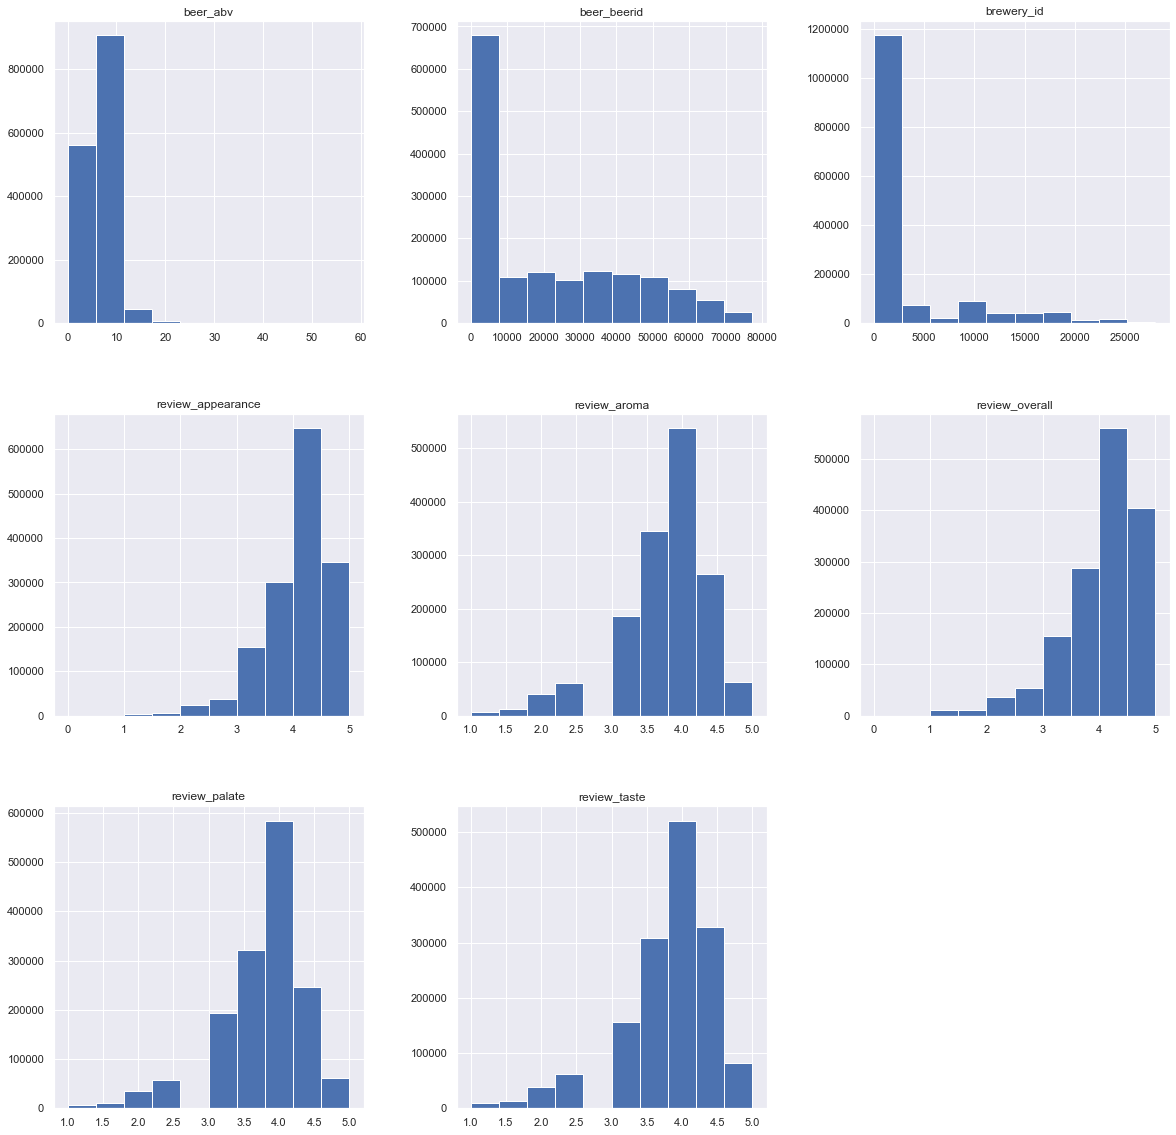

In [49]:
# inspect distribution of dataframe numeric columns
beer_df.hist(figsize = (20,20));


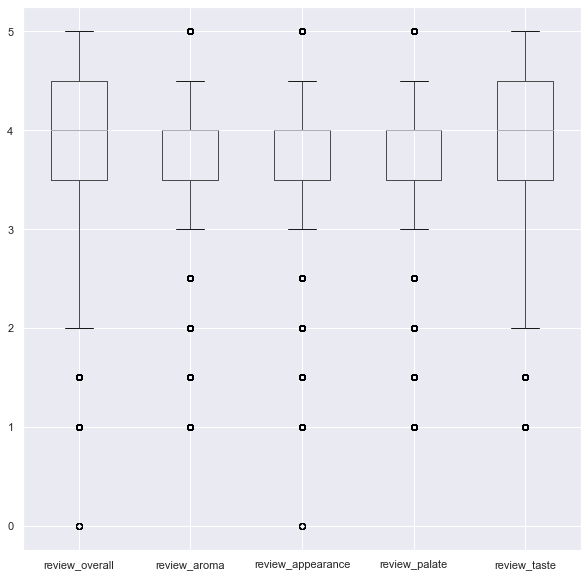

In [20]:
# visualise check of `end station id` to identify outliers
beer_df.boxplot(column=["review_overall","review_aroma", "review_appearance","review_palate", "review_taste"],
                figsize = (10,10), return_type="axes");

